In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 16:23:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   83C    P2   163W / 260W |   5339MiB / 11019MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 33%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2016 = db.rm_patent_us_2016
    db_rm_us_2016 = db.rm_patent_us_2016
    # db_rm_de_2016 = db.rm_patent_de_2016
except errors.ConnectionFailure as err:
    print(err)

# 2016

## Company數量

In [6]:
data_assignee = db_rm_us_2016.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
25,Samsung Electronics Co Ltd,733
12,Intel Corp,273
22,Qualcomm Inc,177
27,Telefonaktiebolaget LM Ericsson AB,143
14,LG Electronics Inc,92
13,International Business Machines Corp,89
4,Cisco Technology Inc,88
16,Microsoft Technology Licensing LLC,56
26,Sony Corp,38
17,NEC Corp,37


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,733,6.597146
1,Intel Corp,273,5.609472
2,Qualcomm Inc,177,5.176150
3,Telefonaktiebolaget LM Ericsson AB,143,4.962845
4,LG Electronics Inc,92,4.521789
5,International Business Machines Corp,89,4.488636
6,Cisco Technology Inc,88,4.477337
7,Microsoft Technology Licensing LLC,56,4.025352
8,Sony Corp,38,3.637586
9,NEC Corp,37,3.610918


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_us_2016.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_us_2016.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AR,AT,AU,BR,CA,CL,CN,CO,DE,...,PT,RS,RU,SE,SG,SI,TN,TW,US,ZA
43,Amazon Technologies Inc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0
130,Cisco Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0
148,Convida Wireless LLC,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0
194,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
333,Intel Corp,0.0,0.0,0.0,3.0,0.0,0.0,50.0,0.0,30.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,19.0,288.0,0.0
342,International Business Machines Corp,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,0.0
385,LG Electronics Inc,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,95.0,0.0
436,Microsoft Technology Licensing LLC,0.0,0.0,1.0,1.0,1.0,1.0,19.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,56.0,1.0
448,NEC Corp,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,5.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,37.0,0.0
452,NTT Docomo Inc,0.0,0.0,0.0,1.0,1.0,1.0,26.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BR,CA,CL,CN,CO,DE,DK,...,PT,RS,RU,SE,SG,SI,TN,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.003951,0.001481,0.001481,0.000000,0.149136,0.000000,0.006914,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.008889,0.374815,0.000000
Intel Corp,0.000000,0.0,0.000000,0.006508,0.000000,0.000000,0.108460,0.000000,0.065076,0.000000,...,0.000000,0.0,0.004338,0.0,0.002169,0.000000,0.00000,0.041215,0.624729,0.000000
Qualcomm Inc,0.001410,0.0,0.032440,0.086037,0.026798,0.007052,0.141044,0.007052,0.000000,0.004231,...,0.002821,0.0,0.008463,0.0,0.008463,0.004231,0.00141,0.063470,0.248237,0.005642
Telefonaktiebolaget LM Ericsson AB,0.019313,0.0,0.010730,0.021459,0.017167,0.000000,0.113734,0.002146,0.000000,0.012876,...,0.008584,0.0,0.038627,0.0,0.000000,0.000000,0.00000,0.002146,0.306867,0.017167
LG Electronics Inc,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.110429,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.006135,0.582822,0.000000


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

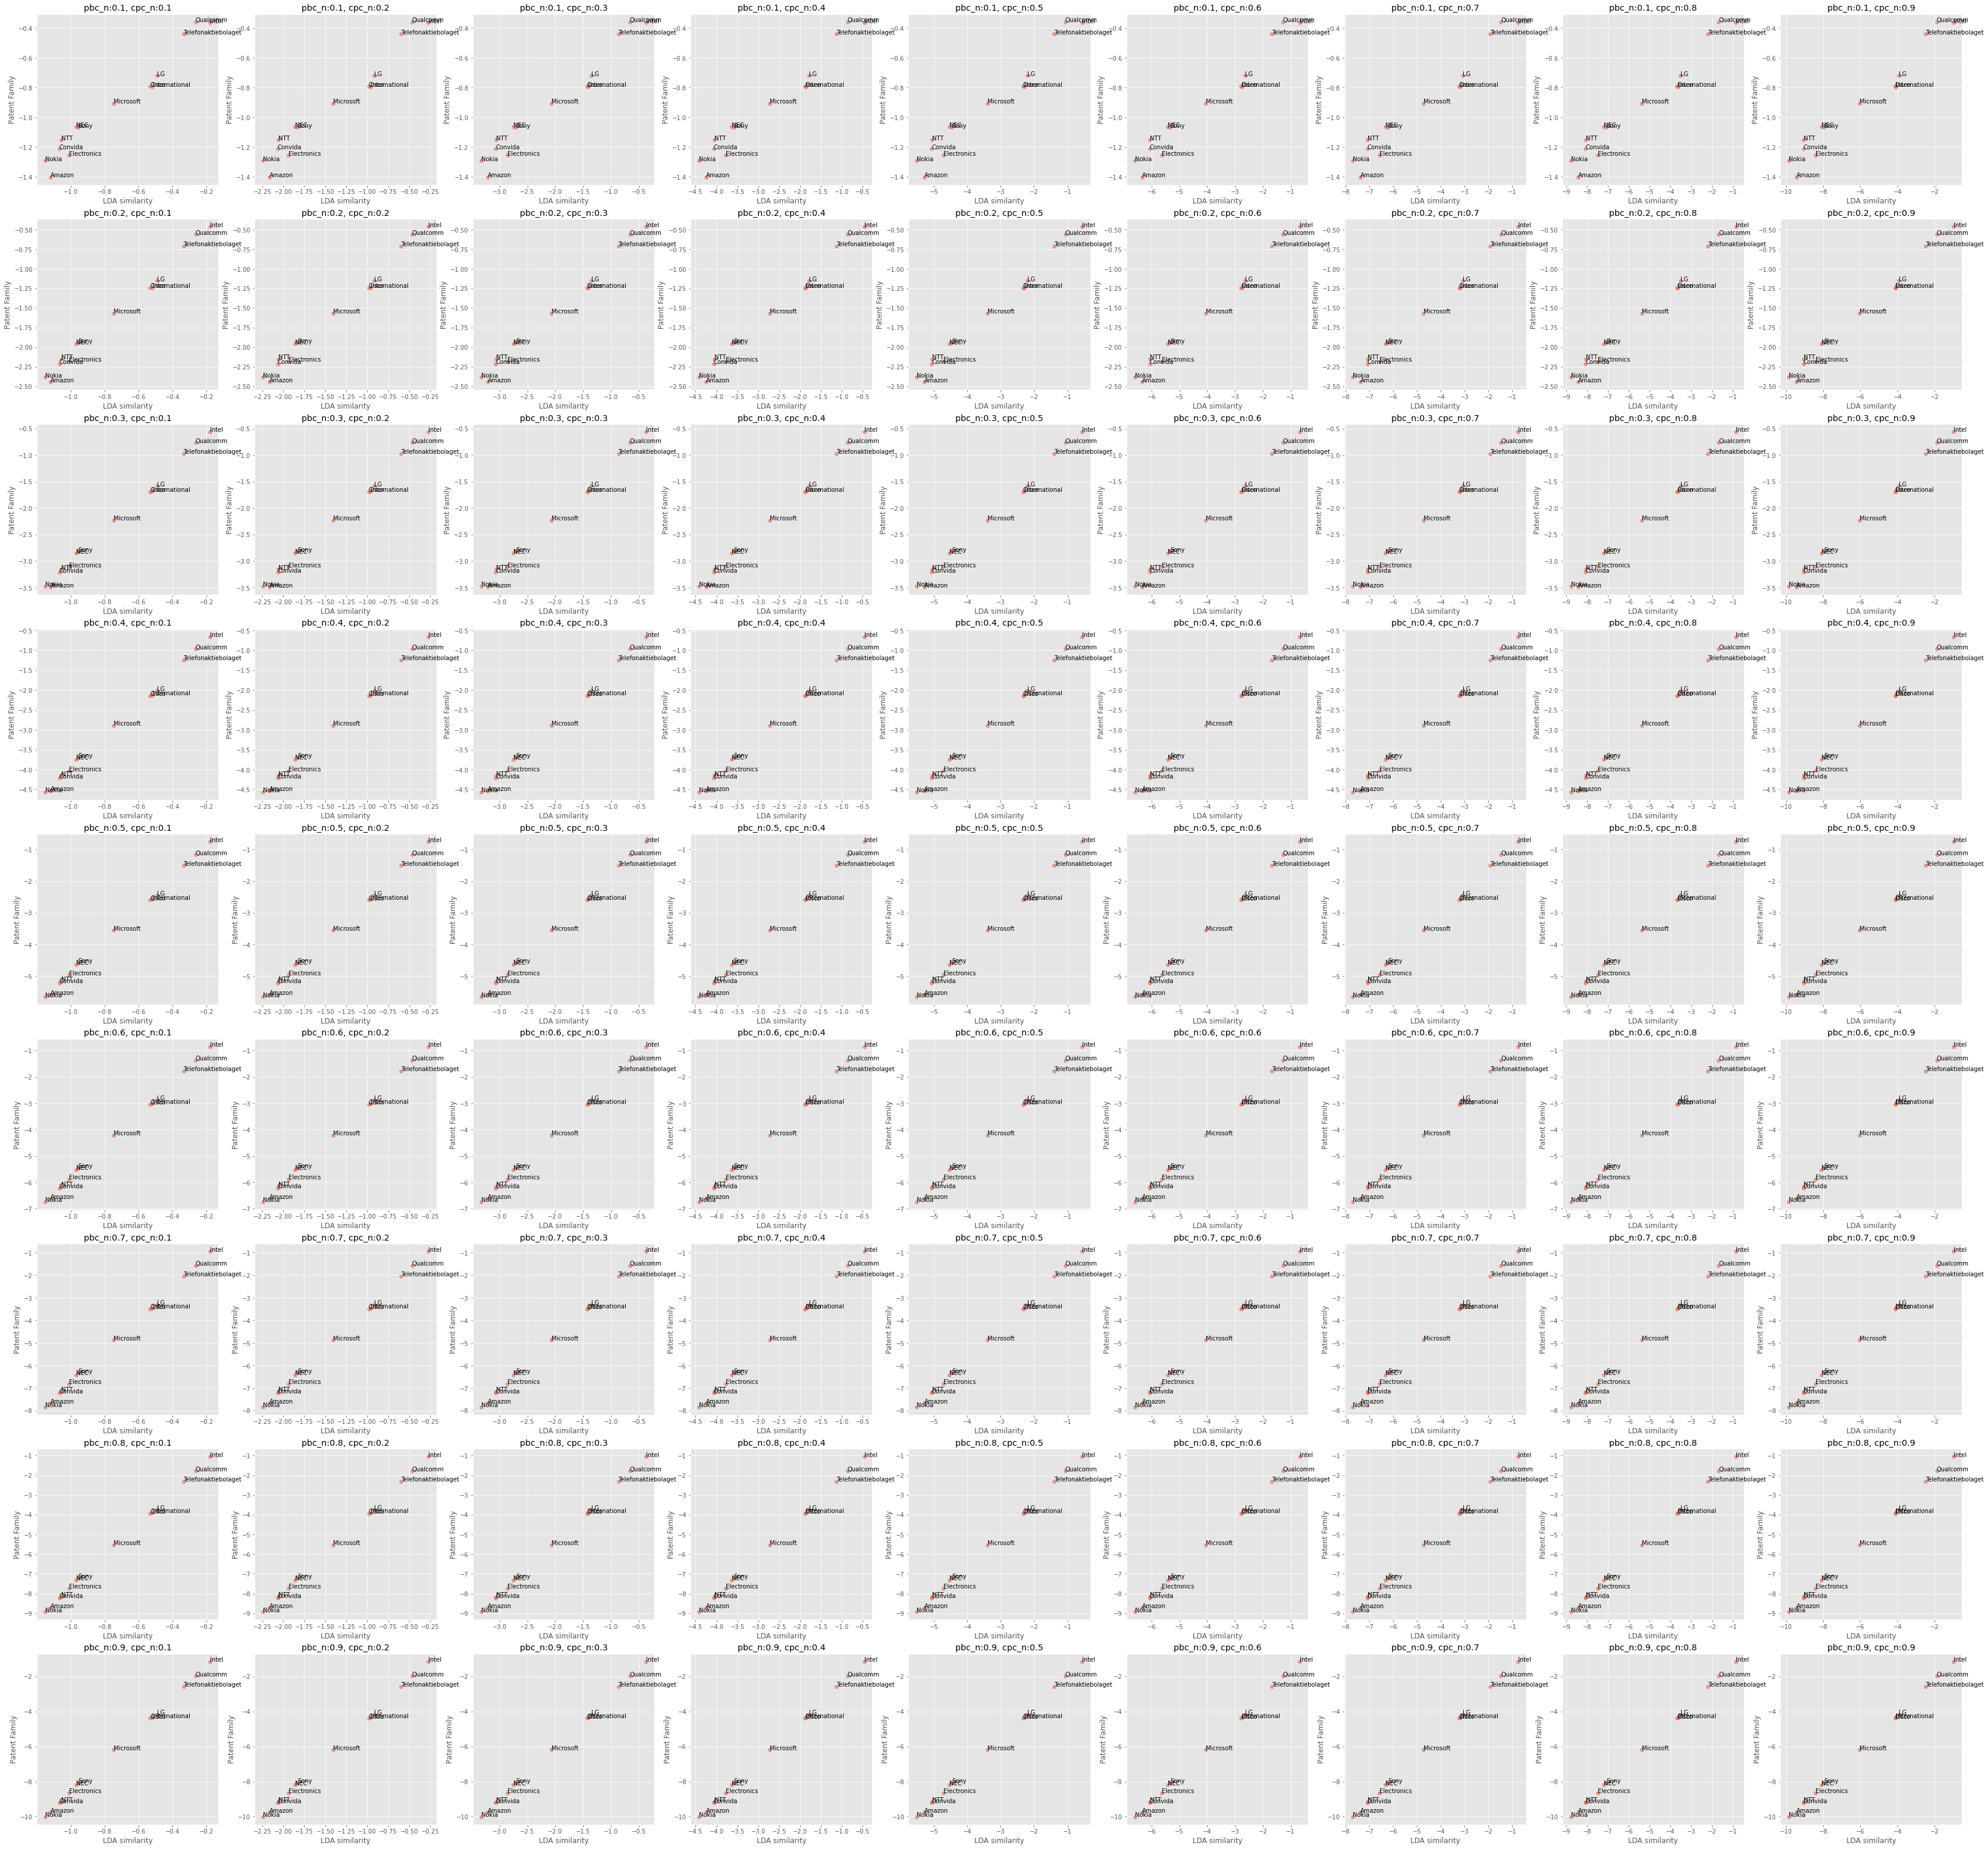

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2016_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Intel Corp,0.957816,1.145938
Qualcomm Inc,1.878575,1.974399
Telefonaktiebolaget LM Ericsson AB,2.471505,2.577562
LG Electronics Inc,3.935653,4.166679
International Business Machines Corp,4.074456,4.351748
Cisco Technology Inc,4.127466,4.387602
Microsoft Technology Licensing LLC,6.036857,6.197265
Sony Corp,7.961789,8.076172
NEC Corp,8.100761,8.199404


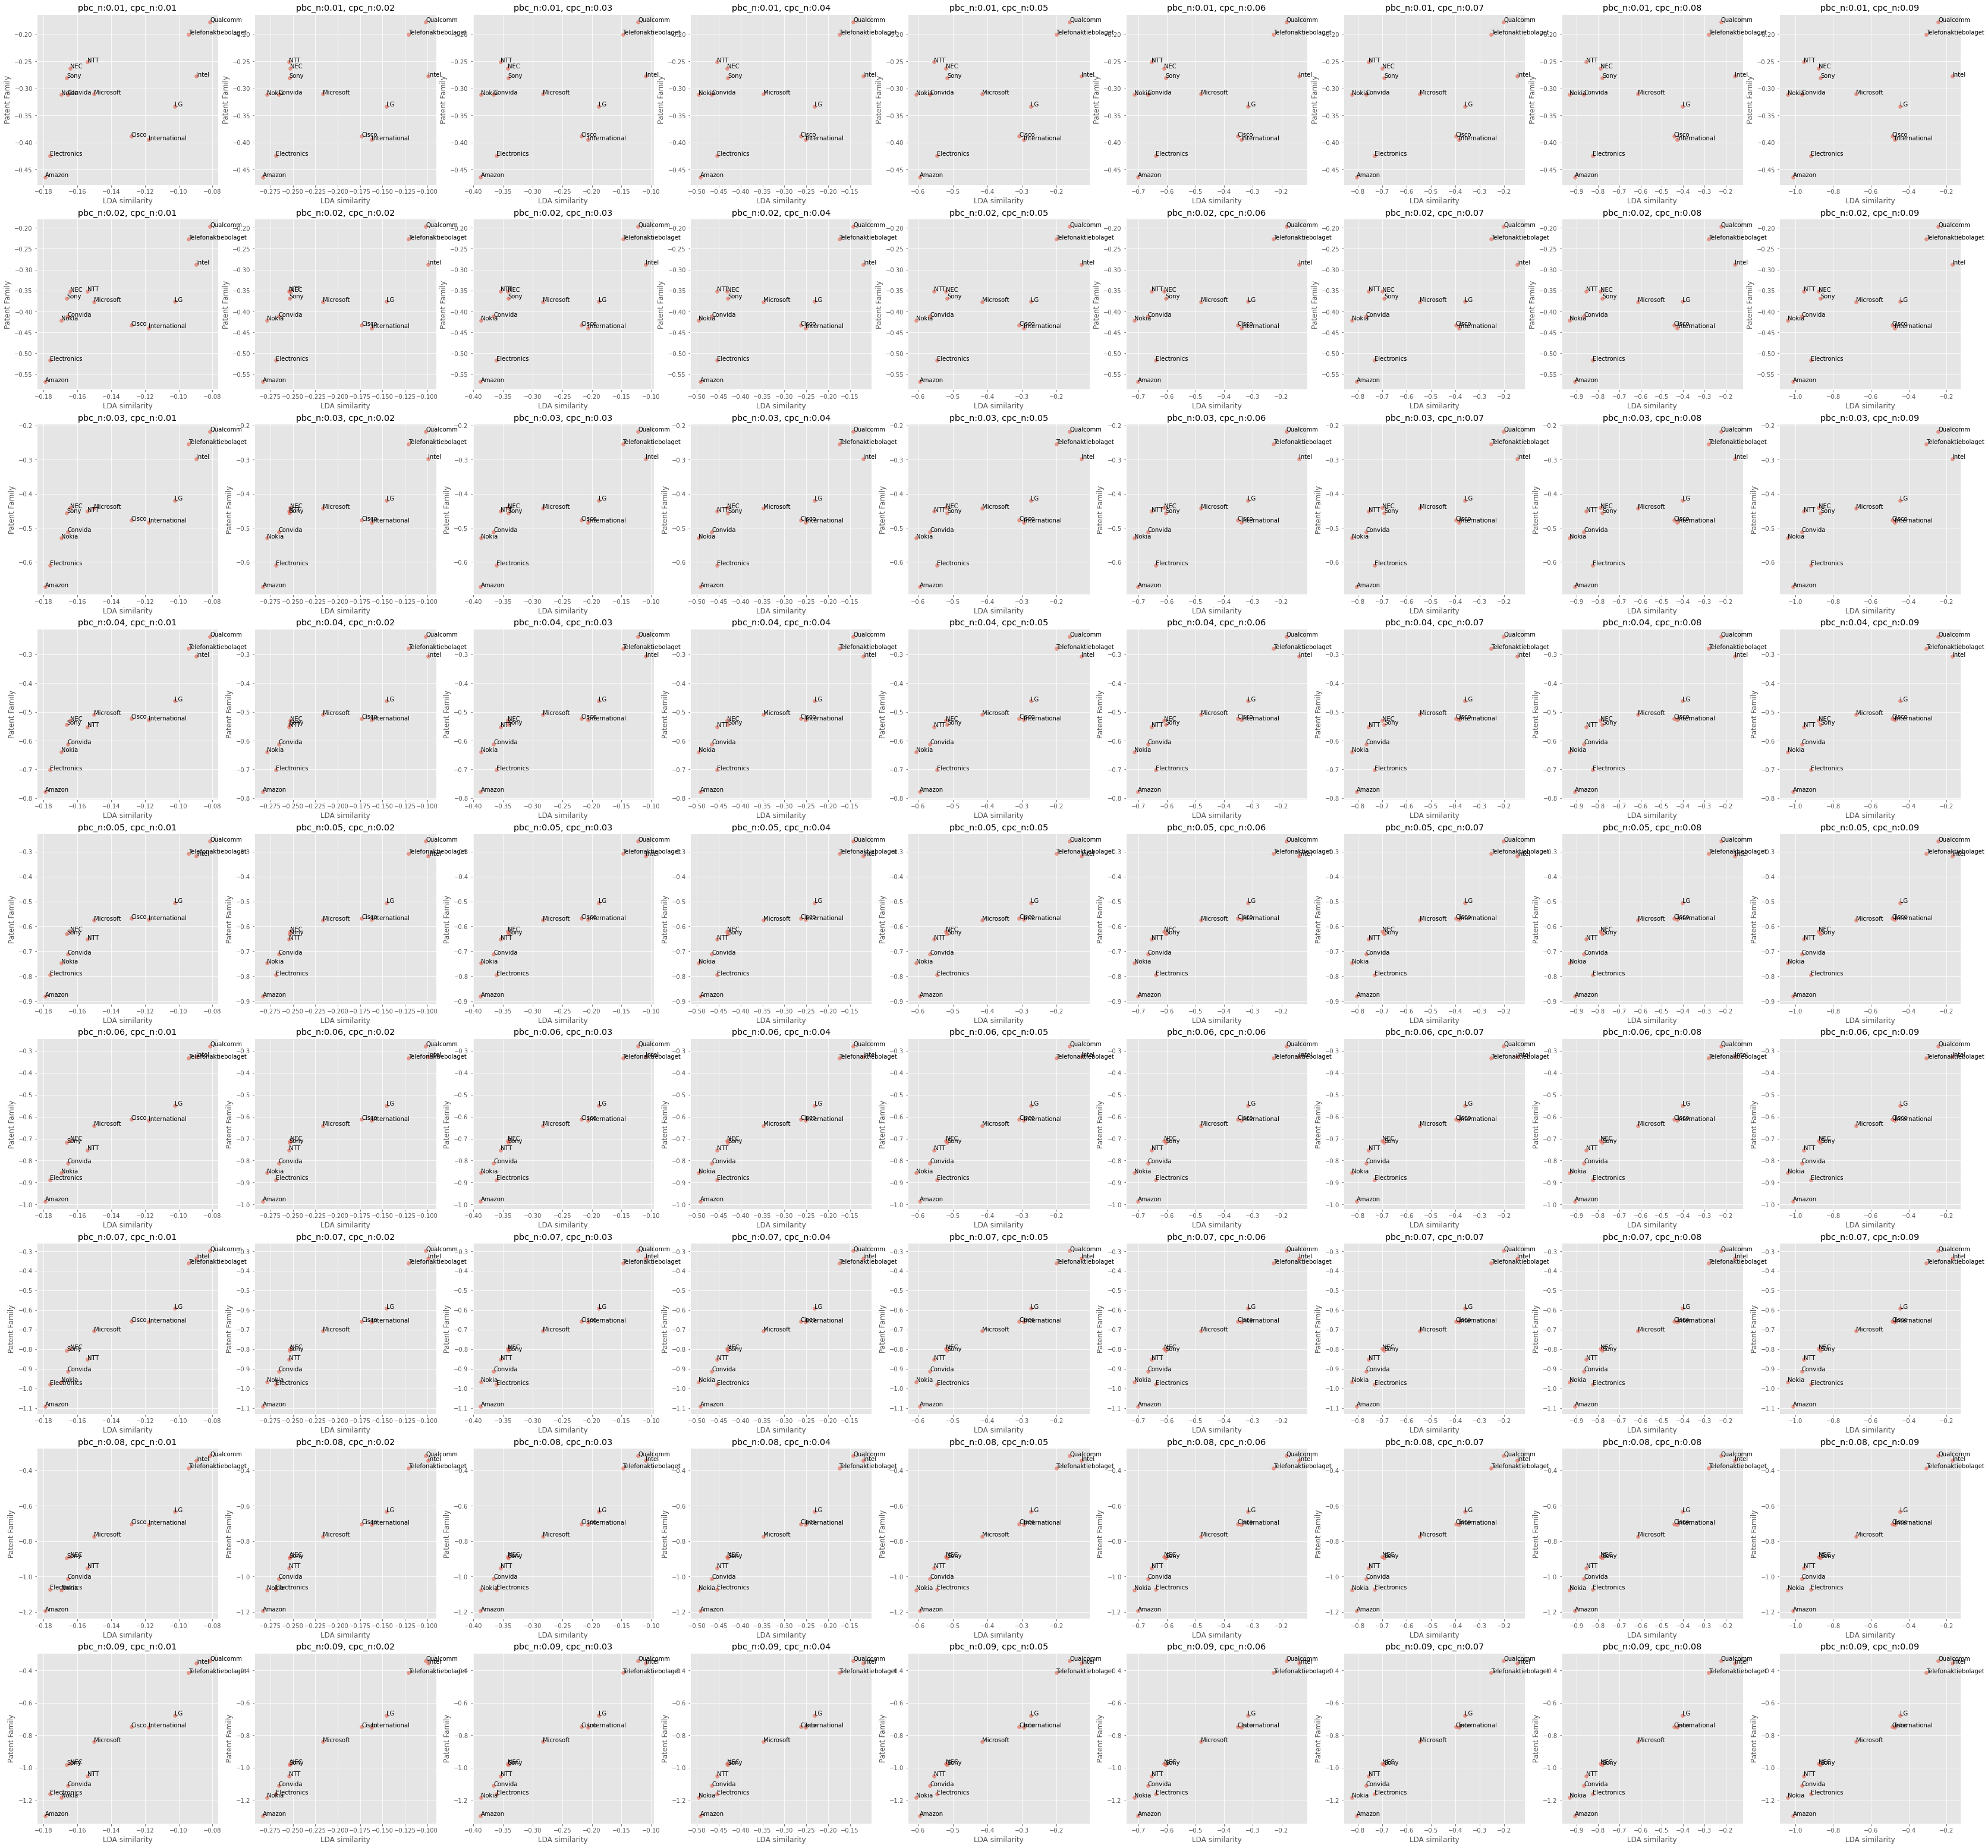

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2016_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Intel Corp,0.167661,0.355784
Qualcomm Inc,0.242999,0.338823
Telefonaktiebolaget LM Ericsson AB,0.308044,0.414100
LG Electronics Inc,0.446896,0.677922
International Business Machines Corp,0.473348,0.750641
Cisco Technology Inc,0.487658,0.747794
Microsoft Technology Licensing LLC,0.679417,0.839824
Sony Corp,0.867005,0.981388
NEC Corp,0.877540,0.976184


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [25]:
c_df

,cpc,country
company,,
Intel,0.167661,0.355784
Qualcomm,0.242999,0.338823
Ericsson,0.308044,0.414100
LG Electronics,0.446896,0.677922
IBM,0.473348,0.750641
Cisco Systems,0.487658,0.747794
Microsoft,0.679417,0.839824
Sony,0.867005,0.981388
NEC,0.877540,0.976184


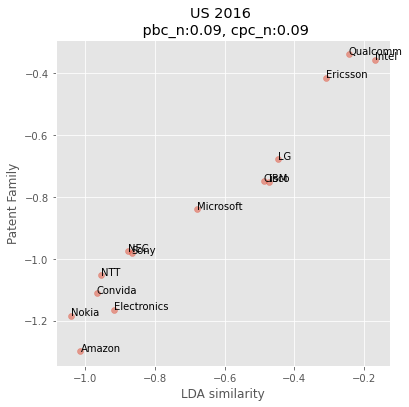

In [26]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("US 2016 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("LDA similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [27]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [28]:
competitor_ls

[1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4]

In [29]:
c_df

,cpc,country
company,,
Intel,0.167661,0.355784
Qualcomm,0.242999,0.338823
Ericsson,0.308044,0.414100
LG Electronics,0.446896,0.677922
IBM,0.473348,0.750641
Cisco Systems,0.487658,0.747794
Microsoft,0.679417,0.839824
Sony,0.867005,0.981388
NEC,0.877540,0.976184


In [30]:
c_df.to_csv("competitor_df/company/lda_us_2016.csv")

In [31]:
# 公司名稱和類別
c_ls = list(c_df.index)

In [32]:
competitor_df = pd.DataFrame((zip(c_ls, competitor_ls)), columns = ['company', '2016_competitor'])

In [33]:
competitor_df

,company,2016_competitor
0,Intel,1
1,Qualcomm,1
2,Ericsson,1
3,LG Electronics,1
4,IBM,1
5,Cisco Systems,1
6,Microsoft,4
7,Sony,4
8,NEC,4
9,Electronics and Telecommunications Research In...,4


In [34]:
competitor_df.to_csv("competitor_df/lda_us_2016.csv", index=False)